Personal objectives for this project:

1. Mastery of data cleaning and feature engineering

2. A dive into app development and translating my data analysis into a front-end product that expresses my work in the most captivating way for the non-techincal audience.

3. In confronting the obstacles of this idea, understanding how I could solve them in the context of the bootcamp deadline while also keeping as thorough a record as possible for how I could solve these problems better in the future versions of this idea.

# Problem Statement (First Draft)

Restaurants may have passed their latest inspection and can be open for business with no problems, but this isn't the full story. More information should be provided to potential customers about the track record of the restaurant so they can make a better informed decision. The goals of this project are:

- A streamlit app which helps people assess the cleanliness of restaurants via visualizations of the restaurant's inspection statistics. This app could 
lower the severity of foodborne outbreaks by informing the customers of potential unsafe food practices of restaurants before they choose to eat there.
- A classification model to predict the inspection result. (logistic regression for most interpretability ?)

**Stretch Goals:**
The results of this project could be scaled to work for multiple cities as well as covering other types of establishments such as hotels, housing units, and even swimming pools. With my app I hope to encourage people to make more informed & healthier choices on things which may impact their health and well-being greatly.


side notes (future):
- process comments to look for key words such as rats/etc in combination with location to tell you if nearby restaurants are suffering from infestations which could affect you.

---
## Imports

In [7]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Setting pandas to display all columns
pd.set_option('display.max_columns', None)

---
## Load Data

**Initial Data Collection Research**

Two potential data sources
- Chicago Data Portal
- New York Data Portal

All cities/counties in the US provide ample data on restaurant inspection, with varying degrees of accessibility, ranging from needing to file a 'request for info' on a per restaurant basis, displaying the data already in json format on the website to be easily scraped or offering downloadable PDFs, to even having all the inspection results stored in a downloadble .csv file all ready to be worked upon. I begun my search considering only major cities as I want my app to have the highest impact possible upon release, and these cities also had more modern data storage techniques.

I narrowed my choices down to Chicago and New York as they came in .csv format with thorough data descriptions and were maintained the best. 

In the end I chose the Chicago dataset as its information is the perfect level of thoroughness without requiring too much cleaning and reorganization considering the limited timeframe of this capstone project. In the future steps of this project, I must explore how to to aggregate multiple cities restaurant inspection info through varied data collection methods in order to generalize this data for the purposes of scaling my app across many regions.

In [11]:
# Chicago Restaurant Inspections
chicago = pd.read_csv('../data/inspection_chicago.csv')
chicago.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2606078,LOOMIS CITGO INC.,LOOMIS CITGO INC.,2523672.0,GAS STATION,Risk 2 (Medium),1356 W 87TH ST,CHICAGO,IL,60620.0,11/07/2024,Canvass Re-Inspection,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.735973,-87.658068,"(41.73597328807627, -87.65806837861354)"
1,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604.0,Restaurant,Risk 1 (High),2926 W 63RD ST,CHICAGO,IL,60629.0,11/06/2024,License,Pass,NaN,41.779173,-87.696989,"(41.779173106768134, -87.69698885824073)"
2,2605986,MOODZ FOOD & DELI,MOODZ FOOD & DELI,2992998.0,Grocery Store,Risk 1 (High),233 W 119TH ST,CHICAGO,IL,60628.0,11/06/2024,License Re-Inspection,Pass,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.677849,-87.628719,"(41.67784867927214, -87.62871899471705)"


In [12]:
print(f'Chicago Inspection Dataset Shape: \n{chicago.shape[0]} observations \n{chicago.shape[1]} features')

Chicago Inspection Dataset Shape: 
108678 observations 
17 features


In [13]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108678 entries, 0 to 108677
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    108678 non-null  int64  
 1   DBA Name         108678 non-null  object 
 2   AKA Name         108420 non-null  object 
 3   License #        108674 non-null  float64
 4   Facility Type    108098 non-null  object 
 5   Risk             108655 non-null  object 
 6   Address          108678 non-null  object 
 7   City             108602 non-null  object 
 8   State            108637 non-null  object 
 9   Zip              108669 non-null  float64
 10  Inspection Date  108678 non-null  object 
 11  Inspection Type  108678 non-null  object 
 12  Results          108678 non-null  object 
 13  Violations       77337 non-null   object 
 14  Latitude         108273 non-null  float64
 15  Longitude        108273 non-null  float64
 16  Location         108273 non-null  obje

--- 
## Data Cleaning

**TO DO**
- convert license_# to float (rename license_#?)
- find num_inspections by restaurant
- remove anything that isn't restaurant?

- rename Inspection Type columns to something more understandable for app

In [15]:
# Checking for duplicate entries
if chicago.duplicated().any():
    print("There are duplicate rows in the dataset.")
else:
    print("No duplicates found.")

No duplicates found.


In [16]:
# Assessment of Null Values
chicago.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name             258
License #              4
Facility Type        580
Risk                  23
Address                0
City                  76
State                 41
Zip                    9
Inspection Date        0
Inspection Type        0
Results                0
Violations         31341
Latitude             405
Longitude            405
Location             405
dtype: int64

- `Latitude`, `Longitude` and `Location` can be dropped as `Address` column is full and the address is what I will need for my app.
- Same goes for `City` and `State`, they will be dropped since for this project we will only be dealing with Chicago, IL establishments.
- `AKA Name` will be useful for my app but not needed for modelling, in the app I will allow a user to look up an establishment by `Address` if `AKA Name` is not available.
- I will likely drop missing `Facility Type` entries since there are so few, however I should research further in EDA why these values might be missing. Perhap it was because of a specific type of inspection or maybe it's missing completely at random.
- Very small amounts of missing `License #` and `Risk` values I will double check what these entries are before dropping them as well..

- The bulk of my cleaning will be to parse the `Violations` column and using EDA to understand how it relates to `Inspection Type` and `Result`. In regards to rows where it is missing, the end goal is to engineer entirely new features such as `violation_count` in which case all these missing values will just be a 0, assuming the missing values aren't diminished greatly once I filter the dataset depending on type of inspection, TBD in EDA.

In [18]:
# Rename Columns
chicago.columns = chicago.columns.str.replace(' ', '_').str.lower()

In [19]:
# Drop unnecessary columns for the time being
chicago.drop(columns = ['latitude', 'longitude', 'city', 'state', 'zip', 'location'], inplace = True)

In [20]:
# Drop rows with negligible missing values
chicago.dropna(subset = ['aka_name', 'license_#', 'risk', 'facility_type'], inplace = True)

In [21]:
# Filling in missing violations column
chicago['violations'] = chicago['violations'].fillna('No Violations')

In [22]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107877 entries, 0 to 108677
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inspection_id    107877 non-null  int64  
 1   dba_name         107877 non-null  object 
 2   aka_name         107877 non-null  object 
 3   license_#        107877 non-null  float64
 4   facility_type    107877 non-null  object 
 5   risk             107877 non-null  object 
 6   address          107877 non-null  object 
 7   inspection_date  107877 non-null  object 
 8   inspection_type  107877 non-null  object 
 9   results          107877 non-null  object 
 10  violations       107877 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 9.9+ MB


## EDA / Feature Engineering

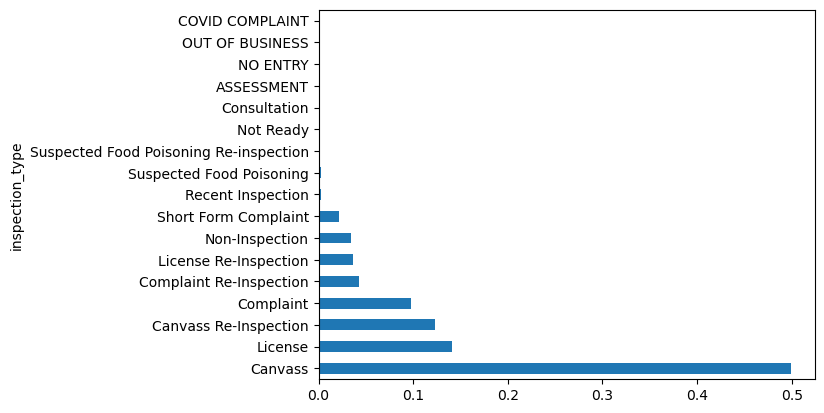

In [24]:
# Inspection Type Frequency
chicago['inspection_type'].value_counts(normalize = True).plot(kind = 'barh');

**Three Most Common Inspection Types**

- Canvass: the most common type of inspection performed at a frequency relative to the `risk` of the establishment.
- License: when the inspection is done as a requirement for the establishment to receive its license to operate.
- Complaint: when the inspection is done in response to a complaint against the establishment.

- Need to find the best way to encode this column for my app and modelling.

**Re-inspections can occur for most of the inspection types.**

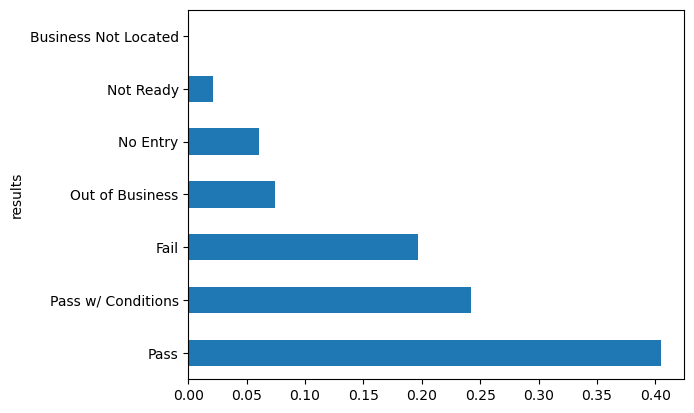

In [26]:
# Inspecton Results
chicago['results'].value_counts(normalize = True).plot(kind = 'barh');

- More than 40% of inspections result in a Pass
- Almost 1 in 5 inspections result in a Fail

In [28]:
# For the purposes of a simpler problem to tackle initially and for easier modelling, I will simplify the results to just Pass or Fail
chicago['results'] = chicago['results'].replace('Pass w/ Conditions', 'Pass')

# Now I will drop results which are not pass or fail
chicago = chicago[chicago['results'].isin(['Pass', 'Fail'])]
chicago.shape

(91035, 11)

- This method is risky as there is a possibility establishments who went out of business or deemed no entry could be re-opened later meaning they should not be removed from my dataset.
- A future workaround to this would be to search for the latest result by each establishment and check if they are still open as of latest inspection.
- I have not lost enough inspection rows to deem this is a necessary task at the moment, but it should be solved eventually.

In [30]:
# Assesing Risk Column
chicago['risk'].value_counts(normalize = True)

risk
Risk 1 (High)      0.792783
Risk 2 (Medium)    0.153073
Risk 3 (Low)       0.054144
Name: proportion, dtype: float64

- Risk 1 (High) being so frequent makes intuitive sense as inspections are performed at a rate relative to the risk factor, so this data would be biased to have higher risk establishments since they are inspected more frequently.

---
### A bulk of my initial work is taking this violations column and turning it into more useful features in order to be visualized.

Once I have my desired features, the EDA will become a lot more effective as I can begin working on my app visualizations simultaneously.

In [33]:
# Observing how violation field is formatted so I can determine how I'd like to parse the values
for violation in chicago['violations'][:3]:
    print(violation)
    print('='*60)

49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: 4-601.11(C) : MUST CLEAN DUST BUILD UP AND DEBRIS FROM WINDOW SILLS,SERVICE COUNTER SHELVING UNITS,WALK IN COOLER-FAN GUARD COVERS AND SHELVING UNITS | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments:  6-201.13: MUST REPAIR OR REPLACE STAINED CEILING TILES AT PREP AREA,REAR STORAGE AREA,DAMAGED WALL AT ENTRY.MUST REMOVE MOLD FROM WALL IN REAR STORAGE NEXT TO COOLER. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments:  6-201.11 : MUST CLEAN DIRT AND DUST BUILD UP FROM WALLS & CEILING IN WALK IN COOLER,REAR DISH WASHING AREA. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments:  6-201.17 : MUST CLEAN DUST BUILD UP FROM CEILING VENTS THROUGHOUT INCLUDING TOILET ROOMS. | 57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING - Comments: : 2-102.13 : OBSERVED NO FOOD HANDLERS TRAINING FOR EMPLOYEES.
No Violations
38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments:  OBSERVED NUMEROUS DEAD ROAC

**Parsing Violation Notes**

- My first task is to extract only the violation code and descriptor elements of this submission, for example, if one violation is written as:

`49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: 4-601.11(C) : MUST CLEAN DUST BUILD UP AND DEBRIS FROM WINDOW SILLS,SERVICE COUNTER SHELVING UNITS,WALK IN COOLER-FAN GUARD COVERS AND SHELVING UNITS |`

I would like to end up with: `49. NON-FOOD/FOOD CONTACT SURFACES CLEAN`

- There is an identifiable pattern in how the violations are written in which I can already see how I can pattern match to retreive the violation part alone: the violation code followed by a period and then the descriptor of the code, then a hyphen before Comments, then a separating bar (|) and the pattern is repeated for each violation.

I can save it as a stretch goal to use NLP techniques to evaluate the `Comments` section and display key words such as type of rodents found and type of dirt discovered.

---
### Parsing Violations Column (Testing)

- I want to break apart this violations column piece by piece so I can work with and display the info in a much easier fashion, this will be my main goal to start off this project.

- An establishment can receive one or more of 45 distinct violations (violation 
numbers 1-44 and 70) Violations are broken down further by critical or serious violations (violation number 1-14 and 15-
29, respectively. I will need to add logic to categorize these violations as such, and that will be another useful feature.--

### Optimizing the previous code block

In [38]:
def process_violations(violations):
    '''
        This function will be applied to the violations column of the dataframe
        and return the features I'd like to create.
    '''

    if violations != 'No Violations':
        violations_list_str = violations.split(' | ')
        violation_count = len(violations_list_str)
        violations_list_code = [int(re.search(r'^\d{1,2}', v).group()) for v in violations_list_str]
    else:
        violation_count = 0
        violations_list_code = []

    return violation_count, violations_list_code

In [39]:
# Apply the function to the main dataframe to generate new columns
chicago[['violation_count', 'violation_codes']] = chicago['violations'].apply(
    lambda x: pd.Series(process_violations(x))
)

In [40]:
chicago.head(10)

,inspection_id,dba_name,aka_name,license_#,facility_type,risk,address,inspection_date,inspection_type,results,violations,violation_count,violation_codes
0,2606078,LOOMIS CITGO INC.,LOOMIS CITGO INC.,2523672.0,GAS STATION,Risk 2 (Medium),1356 W 87TH ST,11/07/2024,Canvass Re-Inspection,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,5,"[49, 55, 55, 55, 57]"
1,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604.0,Restaurant,Risk 1 (High),2926 W 63RD ST,11/06/2024,License,Pass,No Violations,0,[]
2,2605986,MOODZ FOOD & DELI,MOODZ FOOD & DELI,2992998.0,Grocery Store,Risk 1 (High),233 W 119TH ST,11/06/2024,License Re-Inspection,Pass,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",10,"[38, 47, 49, 51, 54, 55, 55, 56, 56, 57]"
3,2606049,SAVE A LOT,SAVE A LOT,2830633.0,Grocery Store,Risk 2 (Medium),10700-10736 S HALSTED ST,11/06/2024,License Re-Inspection,Pass,No Violations,0,[]
5,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421.0,Restaurant,Risk 2 (Medium),1465 W 95TH ST,11/06/2024,Canvass Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,7,"[39, 39, 41, 47, 49, 53, 55]"
6,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207.0,Restaurant,Risk 2 (Medium),30 W ERIE ST,11/06/2024,Canvass,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",4,"[38, 52, 55, 55]"
8,2606024,ANDINA COMFORT FOOD,ANDINA COMFORT FOOD,2997252.0,Restaurant,Risk 1 (High),2325 W TAYLOR ST,11/06/2024,License,Pass,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2,"[3, 58]"
11,2606040,UNCLE BEN'S GRILL,UNCLE BEN'S GRILL,2835481.0,Restaurant,Risk 1 (High),456 N DAMEN AVE,11/06/2024,Complaint,Pass,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,6,"[2, 3, 9, 49, 55, 55]"
12,2606019,TONY'S FAMOUS STEAK & LEMONADE,TONY'S FAMOUS STEAK & LEMONADE,2956392.0,Restaurant,Risk 1 (High),1642 W 79TH ST,11/06/2024,Canvass Re-Inspection,Fail,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,3,"[49, 55, 60]"
15,2606048,WALDO COONEY'S PIZZA,WALDO COONEY'S PIZZA,2996990.0,Restaurant,Risk 1 (High),8541 S PULASKI RD,11/06/2024,License Re-Inspection,Pass,No Violations,0,[]


In [41]:
# Next feature, whether the inspection is first or Re-Inspection
chicago['is_reinspection'] = chicago['inspection_type'].str.contains('Re-Inspection')
chicago.head(3)

,inspection_id,dba_name,aka_name,license_#,facility_type,risk,address,inspection_date,inspection_type,results,violations,violation_count,violation_codes,is_reinspection
0,2606078,LOOMIS CITGO INC.,LOOMIS CITGO INC.,2523672.0,GAS STATION,Risk 2 (Medium),1356 W 87TH ST,11/07/2024,Canvass Re-Inspection,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,5,"[49, 55, 55, 55, 57]",True
1,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604.0,Restaurant,Risk 1 (High),2926 W 63RD ST,11/06/2024,License,Pass,No Violations,0,[],False
2,2605986,MOODZ FOOD & DELI,MOODZ FOOD & DELI,2992998.0,Grocery Store,Risk 1 (High),233 W 119TH ST,11/06/2024,License Re-Inspection,Pass,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",10,"[38, 47, 49, 51, 54, 55, 55, 56, 56, 57]",True


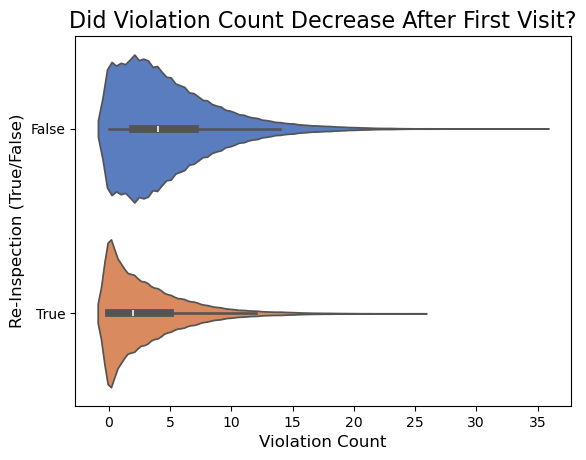

In [42]:
# Distribution of violation count depending if it is reinspection 
sns.violinplot(
    data=chicago,
    x='violation_count',  
    y='is_reinspection', 
    palette='muted',
    hue = 'is_reinspection',
    orient='h',
    legend = False 
)

# Customize plot labels
plt.title('Did Violation Count Decrease After First Visit?', fontsize=16)
plt.xlabel('Violation Count', fontsize=12)
plt.ylabel('Re-Inspection (True/False)', fontsize=12);

---
# Export Processed Data (for streamlit and modelling)

I will export the data worked upon so far in order to make a prototype streamlit app to continue steady progress.

Data cleaning and EDA will be revisited many times over in this process as I discover the more hidden nuances of my streamlit app and modelling process.

In [73]:
chicago.to_csv('../data/processed_chicago.csv', index = False)